In [121]:
import numpy as np
import random
import time
import os
import cv2
import torch
import copy
import json
from pathlib import Path
from PIL import Image
from scipy.misc import imread, imsave
from torch.autograd import Variable
from matplotlib import pyplot as plt

from roi_data_layer.minibatch import get_minibatch, get_minibatch
from model.utils.config import cfg
from model.rpn.bbox_transform import bbox_transform_inv, clip_boxes
from model.utils.blob import prep_im_for_blob, im_list_to_blob
from model.roi_layers import nms
from model.utils.net_utils import vis_detections

In [122]:
def get_model(net, load_path, n_shot, cuda=True):
    if net == 'fsod':
        model = FSOD(['bg', 'fg'], 50, pretrained=False, num_way=2, num_shot=n_shot)
    model.create_architecture()
    print("load checkpoint %s" % (load_path))
    checkpoint = torch.load(load_path)
    model.load_state_dict(checkpoint['model'])
    if 'pooling_mode' in checkpoint.keys():
        cfg.POOLING_MODE = checkpoint['pooling_mode']
    model.eval()
    cfg.CUDA = True
    model.cuda()
    
    return model

def prepare_variable():
    im_data = torch.FloatTensor(1)
    im_info = torch.FloatTensor(1)
    num_boxes = torch.LongTensor(1)
    gt_boxes = torch.FloatTensor(1)
    support_ims = torch.FloatTensor(1)

    im_data = im_data.cuda()
    im_info = im_info.cuda()
    num_boxes = num_boxes.cuda()
    gt_boxes = gt_boxes.cuda()
    support_ims = support_ims.cuda()

    im_data = Variable(im_data)
    im_info = Variable(im_info)
    num_boxes = Variable(num_boxes)
    gt_boxes = Variable(gt_boxes)
    support_ims = Variable(support_ims)

    return im_data, im_info, num_boxes, gt_boxes, support_ims

In [51]:
def support_im_preprocess(im_list, cfg, support_im_size, n_of_shot):
    support_data_all = np.zeros((n_of_shot, 3, support_im_size, support_im_size), dtype=np.float32)
    for i, im in enumerate(im_list):
        im = im[:,:,::-1]  # rgb -> bgr
        target_size = np.min(im.shape[0:2])  # don't change the size
        im, _ = prep_im_for_blob(im, cfg.PIXEL_MEANS, target_size, cfg.TRAIN.MAX_SIZE)
        _h, _w = im.shape[0], im.shape[1]
        if _h > _w:
            resize_scale = float(support_im_size) / float(_h)
            unfit_size = int(_w * resize_scale)
            im = cv2.resize(im, (unfit_size, support_im_size), interpolation=cv2.INTER_LINEAR)
        else:
            resize_scale = float(support_im_size) / float(_w)
            unfit_size = int(_h * resize_scale)
            im = cv2.resize(im, (support_im_size, unfit_size), interpolation=cv2.INTER_LINEAR)
        h, w = im.shape[0], im.shape[1]
        support_data_all[i, :, :h, :w] = np.transpose(im, (2, 0, 1))
    support_data = torch.from_numpy(support_data_all).unsqueeze(0)
    
    return support_data

def query_im_preprocess(im_data, cfg):
    target_size = cfg.TRAIN.SCALES[0]
    im_data, im_scale = prep_im_for_blob(im_data, cfg.PIXEL_MEANS, target_size, cfg.TRAIN.MAX_SIZE)
    im_data = torch.from_numpy(im_data)
    im_info = np.array([[im_data.shape[0], im_data.shape[1], im_scale]], dtype=np.float32)
    im_info = torch.from_numpy(im_info)
    gt_boxes = torch.from_numpy(np.array([0]))
    num_boxes = torch.from_numpy(np.array([0]))
    query = im_data.permute(2, 0, 1).contiguous().unsqueeze(0)
    
    return query, im_info, gt_boxes, num_boxes
    

### prepare support

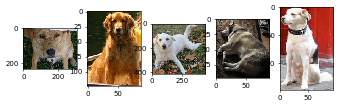

In [16]:
root_dir = '/home/tony/datasets/supports'
class_dir = 'tennis'
n_shot = 5
im_paths = list(Path(os.path.join(root_dir, class_dir)).glob('*.jpg'))
random.seed(0)
im_path_list = random.sample(im_paths, k=n_shot)
im_list = []
fig = plt.figure(num=None, figsize=(8, 8), dpi=50, facecolor='w', edgecolor='k')
for i, im_path in enumerate(im_path_list):
    im = Image.open(im_path)
    im_list.append(np.asarray(im))
    plt.subplot(1, 5, i+1)
    plt.imshow(im)
    
support_data = support_im_preprocess(im_list, cfg, 320, n_shot)

### prepare query

In [52]:
cwd = os.getcwd()
coco_json_path = cwd + '/data/coco/annotations/instances_val2014.json'
with open(coco_json_path, 'r') as f:
    data = json.load(f)
data.keys()

im_summary = {}
for i, im_d in enumerate(data['images']):
    im_summary[str(im_d['id'])] = {}
    im_summary[str(im_d['id'])]['im_dict'] = im_d
    im_summary[str(im_d['id'])]['annotations'] = []
    im_summary[str(im_d['id'])]['categories'] = []
for j, a_d in enumerate(data['annotations']):
    if a_d['iscrowd'] == 0:  # only keep non-crowd annotations
        im_id = a_d['image_id']
        cat_id = a_d['category_id']
        im_summary[str(im_id)]['annotations'].append(a_d)
        im_summary[str(im_id)]['categories'].append(cat_id)
for _key in im_summary.keys():
    im_summary[_key]['categories'] = list(set(im_summary[_key]['categories']))

In [83]:
cwd = os.getcwd()
im_dir = os.path.join(cwd, 'data/coco/images/val2014')
target_ind = 18
target_im_dict_list = []
for _key in im_summary.keys():
    im_dict = im_summary[_key]['im_dict']
    if target_ind in im_summary[_key]['categories']:
        target_im_dict_list.append(im_dict)
random.seed(0)
im_dict_list = random.sample(target_im_dict_list, k=50)

im_path_list = []
gt_boxes_list = []
for im_dict in im_dict_list:
    im_path_list.append(os.path.join(im_dir, im_dict['file_name']))

/home/tony/FSOD/data/coco/images/val2014/COCO_val2014_000000457882.jpg


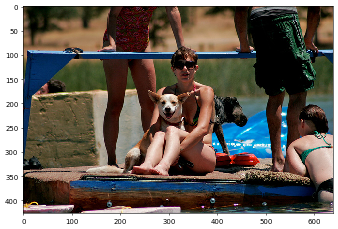

In [109]:
# n = 2
n = 39
print(im_path_list[n])
im = np.asarray(Image.open(im_path_list[n]))
fig = plt.figure(num=None, figsize=(8, 8), dpi=50, facecolor='w', edgecolor='k')
plt.imshow(im)
query, im_info, gt_boxes, num_boxes = query_im_preprocess(im, cfg)

### predict

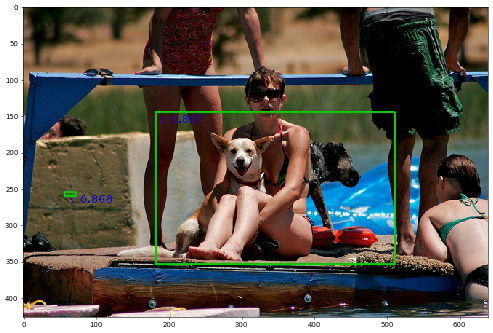

In [117]:
# FSOD
CWD = os.getcwd()
output_path = os.path.join(CWD, 'output/visualization', 'tmp.jpg')
im_scale = 1.405
im_result = Image.open(output_path)
fig = plt.figure(num=None, figsize=(12, 12), dpi=50, facecolor='w', edgecolor='k')
plt.imshow(im_result)

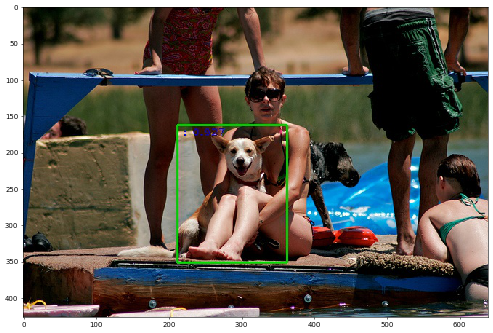

In [115]:
# NARPN
CWD = os.getcwd()
output_path = os.path.join(CWD, 'output/visualization', 'tmp.jpg')
im_scale = 1.405
im_result = Image.open(output_path)
fig = plt.figure(num=None, figsize=(12, 12), dpi=50, facecolor='w', edgecolor='k')
plt.imshow(im_result)

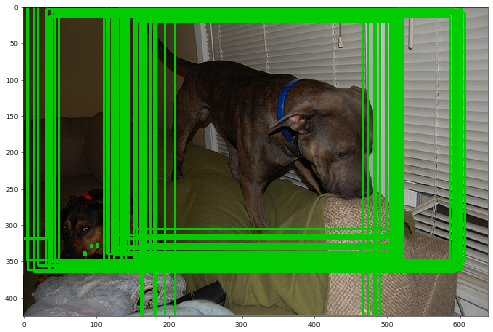

In [101]:
# QKV
im2show = im.copy()
proposals = np.load(os.path.join(CWD, 'output/visualization/proposals.npy'))
scores = np.load(os.path.join(CWD, 'output/visualization/scores.npy'))
for i in range(64):
    bbox = tuple(int(np.round(x) / im_scale) for x in proposals[i, :4])
    cv2.rectangle(im2show, bbox[0:2], bbox[2:4], (0, 204, 0), 2)
fig = plt.figure(num=None, figsize=(12, 12), dpi=50, facecolor='w', edgecolor='k')
plt.imshow(im2show)

In [45]:
proposals[:30]

array([[122.31055 , 417.26175 , 126.31337 , 421.53574 ],
       [125.50241 , 403.63422 , 129.83145 , 407.48328 ],
       [119.14186 , 183.81613 , 125.242966, 188.97116 ],
       [118.85038 , 204.93098 , 125.13543 , 210.74025 ],
       [ 99.02518 , 522.5666  , 105.816986, 529.99567 ],
       [120.67919 , 233.34009 , 126.74938 , 239.51575 ],
       [  0.      , 315.49548 ,   0.      , 337.5028  ],
       [117.80848 , 170.43947 , 124.08718 , 175.27605 ],
       [  0.      , 335.92325 ,   0.      , 358.72202 ],
       [122.68865 , 434.5497  , 126.873024, 439.3112  ],
       [  0.      , 470.2238  ,   0.      , 492.34122 ],
       [120.52027 , 445.42303 , 125.02761 , 450.67523 ],
       [115.601524, 459.38544 , 120.63647 , 464.99725 ],
       [  0.      , 295.74524 ,   0.      , 316.3864  ],
       [121.68327 , 270.24753 , 127.97417 , 276.7903  ],
       [  0.      , 348.3801  ,   0.      , 371.8458  ],
       [125.6866  , 394.44818 , 130.40672 , 398.06427 ],
       [122.436714, 259.59818 ,

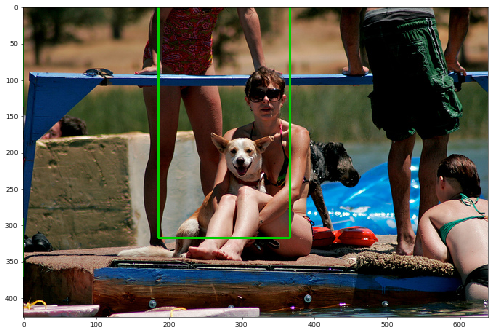

In [119]:
# FSOD
im2show = im.copy()
proposals = np.load(os.path.join(CWD, 'output/visualization/proposals.npy'))
scores = np.load(os.path.join(CWD, 'output/visualization/scores.npy'))
for i in range(64):
    bbox = tuple(int(np.round(x) / im_scale) for x in proposals[i, :4])
    cv2.rectangle(im2show, bbox[0:2], bbox[2:4], (0, 204, 0), 2)
fig = plt.figure(num=None, figsize=(12, 12), dpi=50, facecolor='w', edgecolor='k')
plt.imshow(im2show)

In [120]:
proposals[:30]

array([[  0.      ,  44.244785,   0.      ,  51.328854],
       [822.1893  ,   0.      , 827.6945  ,   0.      ],
       [  0.      ,  80.84701 ,   0.      ,  93.44759 ],
       [  0.      ,  91.372536,   0.      , 104.15444 ],
       [  0.      ,  96.95935 ,   0.      , 109.73718 ],
       [  0.      , 104.28937 ,   0.      , 117.74797 ],
       [  0.      ,   0.      ,   0.      ,   0.      ],
       [236.72385 ,   0.      , 242.27615 ,   0.      ],
       [617.8868  ,   0.      , 627.4079  ,   0.      ],
       [  0.      ,  58.72335 ,   0.      ,  72.687126],
       [  0.      , 113.950966,   0.      , 130.96626 ],
       [222.43073 ,   0.      , 227.54681 ,   0.      ],
       [254.35654 ,   0.      , 260.68698 ,   0.      ],
       [604.6518  ,   0.      , 613.82916 ,   0.      ],
       [432.44522 ,   0.      , 441.17557 ,   0.      ],
       [492.71106 ,   0.      , 503.87732 ,   0.      ],
       [  0.      , 453.06143 ,   0.      , 481.70187 ],
       [207.63239 ,   0.      ,

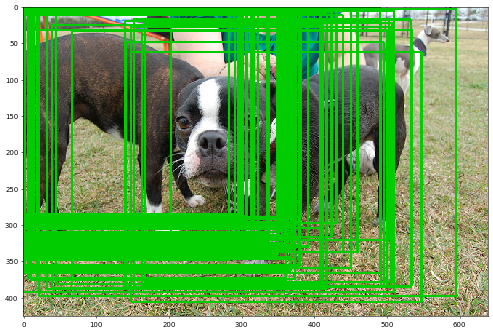

In [87]:
# Faster RCNN
im2show = im.copy()
proposals = np.load(os.path.join(CWD, 'output/visualization/proposals.npy'))
scores = np.load(os.path.join(CWD, 'output/visualization/scores.npy'))
for i in range(64):
    bbox = tuple(int(np.round(x) / im_scale) for x in proposals[i, :4])
    cv2.rectangle(im2show, bbox[0:2], bbox[2:4], (0, 204, 0), 2)
fig = plt.figure(num=None, figsize=(12, 12), dpi=50, facecolor='w', edgecolor='k')
plt.imshow(im2show)

In [48]:
proposals[:30]

array([[487.2223    ,   4.563217  , 642.60034   , 396.5407    ],
       [489.71643   ,  30.99141   , 634.57605   , 392.39893   ],
       [596.48724   ,  55.528336  , 746.206     , 458.6803    ],
       [488.5031    ,  42.95349   , 629.3494    , 382.1282    ],
       [589.51044   ,  65.79643   , 748.9461    , 435.06213   ],
       [484.01962   ,   0.        , 643.0765    , 382.03122   ],
       [497.37308   ,   5.2013855 , 643.1068    , 379.9832    ],
       [493.92474   ,   6.3845367 , 639.8505    , 391.81805   ],
       [596.3421    ,  53.952087  , 747.48773   , 453.5299    ],
       [591.1521    ,  46.045227  , 754.34985   , 372.0981    ],
       [611.5837    ,  58.447952  , 760.8818    , 431.9696    ],
       [493.529     ,   0.        , 640.96747   , 383.16125   ],
       [492.4488    ,   0.        , 647.00446   , 378.1054    ],
       [600.0148    ,  58.700058  , 751.8605    , 441.7005    ],
       [585.46735   ,  62.003708  , 738.21295   , 407.6855    ],
       [506.60638   ,  21

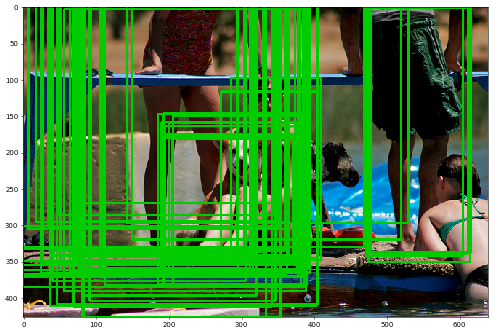

In [116]:
# NARPN
im2show = im.copy()
proposals = np.load(os.path.join(CWD, 'output/visualization/proposals.npy'))
scores = np.load(os.path.join(CWD, 'output/visualization/scores.npy'))
for i in range(64):
    bbox = tuple(int(np.round(x) / im_scale) for x in proposals[i, :4])
    cv2.rectangle(im2show, bbox[0:2], bbox[2:4], (0, 204, 0), 2)
fig = plt.figure(num=None, figsize=(12, 12), dpi=50, facecolor='w', edgecolor='k')
plt.imshow(im2show)

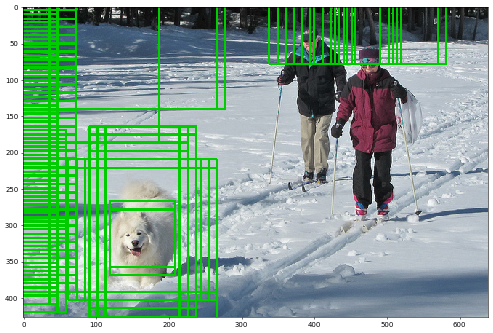

In [15]:
# QKV
im2show = im.copy()
proposals = np.load(os.path.join(CWD, 'output/visualization/anchors.npy'))
scores = np.load(os.path.join(CWD, 'output/visualization/scores.npy'))
for i in range(128):
    bbox = tuple(int(np.round(x) / im_scale) for x in proposals[i, :4])
    cv2.rectangle(im2show, bbox[0:2], bbox[2:4], (0, 204, 0), 2)
fig = plt.figure(num=None, figsize=(12, 12), dpi=50, facecolor='w', edgecolor='k')
plt.imshow(im2show)

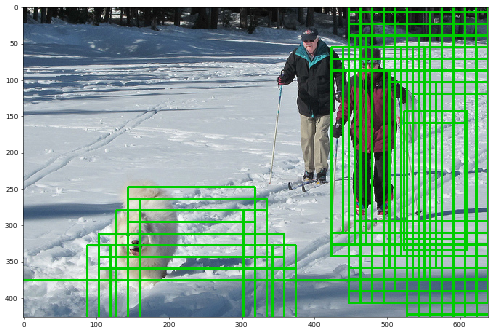

In [26]:
# FR
im2show = im.copy()
proposals = np.load(os.path.join(CWD, 'output/visualization/anchors.npy'))
scores = np.load(os.path.join(CWD, 'output/visualization/scores.npy'))
for i in range(128):
    bbox = tuple(int(np.round(x)) for x in proposals[i, :4])
    cv2.rectangle(im2show, bbox[0:2], bbox[2:4], (0, 204, 0), 2)
fig = plt.figure(num=None, figsize=(12, 12), dpi=50, facecolor='w', edgecolor='k')
plt.imshow(im2show)

### for simulation

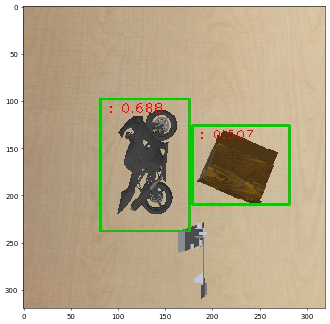

In [36]:
output_path = os.path.join(CWD, 'data/simulated/output/tmp_1.jpg')
im2show = Image.open(output_path)
fig = plt.figure(num=None, figsize=(8, 8), dpi=50, facecolor='w', edgecolor='k')
plt.imshow(im2show)

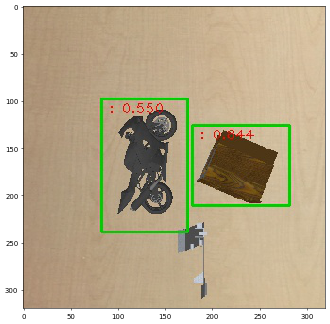

In [37]:
output_path = os.path.join(CWD, 'data/simulated/output/tmp_3.jpg')
im2show = Image.open(output_path)
fig = plt.figure(num=None, figsize=(8, 8), dpi=50, facecolor='w', edgecolor='k')
plt.imshow(im2show)

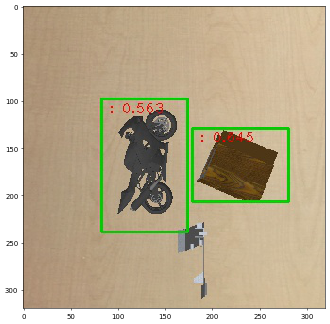

In [38]:
output_path = os.path.join(CWD, 'data/simulated/output/tmp_5.jpg')
im2show = Image.open(output_path)
fig = plt.figure(num=None, figsize=(8, 8), dpi=50, facecolor='w', edgecolor='k')
plt.imshow(im2show)

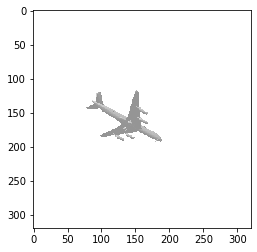

In [19]:
_im = np.load('/home/tony/Desktop/tmp.npy')
plt.imshow(_im.astype(np.int16))

In [23]:
_im.dtype

dtype('float64')